<a href="https://colab.research.google.com/github/marjansherafati/Tensorflow-for-Horses-vs-Humans-using-transfer-learning/blob/master/Horses_vs_Humans_in_TF_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Horses vs Humans classification in Tensorflow using Transfer Learning

The goal in this notebook is to use a pre-trained model from Inception V3 and use it to train a horses vs humans classifier with a 99.9% accuracy.

The beauty of transfer learning is that we can use models that were developed by other researchers, possibly using larger datasets and better machines, and we can build our model on top of that.

For more information about the inception V3 model, please visit https://cloud.google.com/tpu/docs/inception-v3-advanced

We start by importing all the necessary files

In [0]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

Next we download the pre-trained model, and the weights for it.

we then specify that we want the model to take the local weights that we separately downloaded

We also set all layers in the pre_trained model to be non-trainable. This way, our neural network will not attempt to learn the weights that we already have, and will focus on training the lower dense layers of the neural network

In [0]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape= (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()


--2019-10-14 17:37:29--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 2607:f8b0:4001:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   181MB/s    in 0.5s    

2019-10-14 17:37:30 (181 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                               

In [0]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


We also want to have a callback function, so that we can stop training once we reached the desired accuracy (99.9%)

In [0]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

      

Next I will define the dense layers that I want to put on top of the pre-trained model, to train for the task in hand.

I first flatten the output from the last pre-trained layer, add two dense layers (one fully connected layer with 1024 units and one output layer with one sigmoid unit) and compile the model.

As in previous notebooks, I am using RMSprop as my optimizer (more info at https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a), and binary cross-entropy as my loss function

I'm also using a dropout rate of 0.2 to avoid overfitting in my training data

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     


# Data Pre-processing

In this section, I download the horse vs human dataset. More info about this dataset can be found at http://www.laurencemoroney.com/horses-or-humans-dataset/


In [0]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2019-10-14 17:40:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   157MB/s    in 0.9s    

2019-10-14 17:40:01 (157 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2019-10-14 17:40:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [applicati

In [0]:
train_horses_dir = "/tmp/training/horses/"
train_humans_dir = "/tmp/training/humans/"
validation_horses_dir = "/tmp/validation/horses/"
validation_humans_dir = "/tmp/validation/humans/"


print(len(os.listdir("/tmp/training/horses/")))
print(len(os.listdir("/tmp/training/humans/")))
print(len(os.listdir("/tmp/validation/horses/")))
print(len(os.listdir("/tmp/validation/humans/")))

500
527
128
128


Next, I use ImageDataGenerator to create the input data, and perform data augmentation

In [0]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(      
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode ='binary',
                                                    target_size=(150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                    batch_size = 20,
                                                    class_mode ='binary',
                                                    target_size=(150, 150))


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In the code block below, I fit the model to the data. I have allowed the model to continue for 100 epochs, but we will stop the training once the training set accuracy has reached 99.9%

In [0]:

callbacks = myCallback()
history = model.fit_generator(train_generator,
                              epochs=100,
                              verbose = 1,
                              validation_data = validation_generator,
                              callbacks = [callbacks])

Epoch 1/100
52/52 [==============================] - 23s 449ms/step - loss: 0.2878 - acc: 0.8724 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 2/100
52/52 [==============================] - 13s 241ms/step - loss: 0.0972 - acc: 0.9601 - val_loss: 5.4832e-04 - val_acc: 1.0000
Epoch 3/100
52/52 [==============================] - 14s 268ms/step - loss: 0.0683 - acc: 0.9737 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 4/100
52/52 [==============================] - 14s 269ms/step - loss: 0.0644 - acc: 0.9786 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 5/100
52/52 [==============================] - 14s 269ms/step - loss: 0.0716 - acc: 0.9747 - val_loss: 0.0033 - val_acc: 0.9961
Epoch 6/100
52/52 [==============================] - 14s 271ms/step - loss: 0.0311 - acc: 0.9883 - val_loss: 0.0863 - val_acc: 0.9766
Epoch 7/100
52/52 [==============================] - 14s 270ms/step - loss: 0.0407 - acc: 0.9883 - val_loss: 7.2891e-05 - val_acc: 1.0000
Epoch 8/100
52/52 [==============================] - 1

we observe that after about 52 epochs, we reach the desired accuracy on the training set.

Let's plot the training and validation accuracy vs epochs to see how accuracy is evolving with time

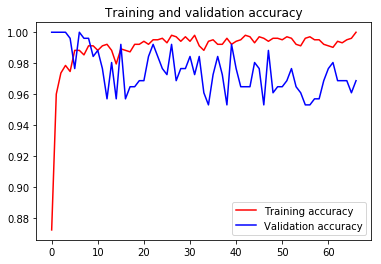

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

As can be seen, the training set accuracy is increasing with each epoch, but the validation set accuracy is oscillating. This means that our methods of overffiting have still not done much to avoid overfitting on the training set